In [1]:
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime

sys.path.append('../scripts')

from data_download import download_data
from load_data import load_files, load_earthquakes_data

from other_functions import valid_year
from plot_data import plot_earthquakes_time_histogram

In [2]:
usgs_folder_path="../ressources/usgs"
current_year = datetime.now().year
mag_outlayer_threshold = 2.5
threshold_year = 1950
prev_years = 53

Downloading and loading raw data

In [3]:
download_data(prev_years, folder_path=usgs_folder_path)

Year 2023 -> file too large... splitting into 2
Year 2023, part 1 -> file downloaded


Year 2023, part 2 -> file downloaded


In [4]:
data_files = load_files("earthquake",folder_path=usgs_folder_path)
fyear = valid_year(data_files, fyear = threshold_year)
earthquake_db = load_earthquakes_data(start_year = fyear, end_year = current_year, files_list = data_files, folder_path=usgs_folder_path, raw_data=True)

using 75 files over 54 years.



Feature selection: 

Our dataset contains 25 features. However, most of them are useless.

The ones we really want to keep are : 

    id : To identify each earthquake
    time : To know when the earthquake happened
    place, latitude, longitude, depth : To know where it happened
    mag : To know the magnitude of the earthquake
    horizontalError, depthError, magError : To filter the data so we can keep the most accurate ones

In [5]:
earthquake_db.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 948342 entries, 0 to 9510
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   time             948342 non-null  object 
 1   latitude         948342 non-null  float64
 2   longitude        948342 non-null  float64
 3   depth            948315 non-null  float64
 4   mag              948342 non-null  float64
 5   magType          948259 non-null  object 
 6   nst              472815 non-null  float64
 7   gap              588895 non-null  float64
 8   dmin             303662 non-null  float64
 9   rms              788304 non-null  float64
 10  net              948342 non-null  object 
 11  id               948342 non-null  object 
 12  updated          948342 non-null  object 
 13  place            945077 non-null  object 
 14  type             948342 non-null  object 
 15  horizontalError  324086 non-null  float64
 16  depthError       544977 non-null  float6

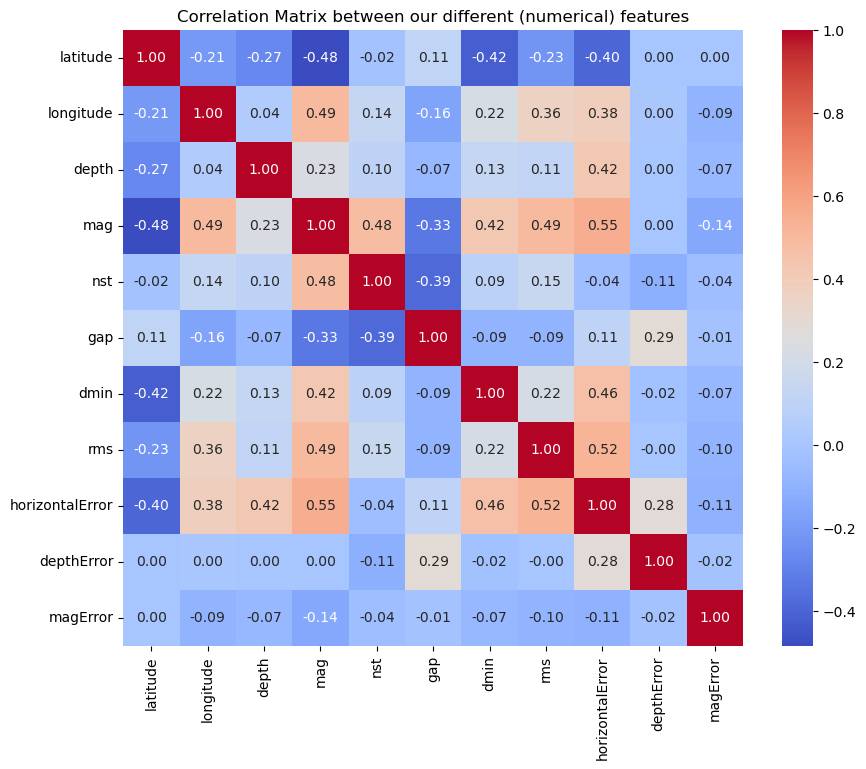

In [6]:
correlation_matrix = earthquake_db[['latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'dmin', 'rms', 'horizontalError', 'depthError', 'magError']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix between our different (numerical) features")
plt.show()

---

### Data filtering:

    Some data is missing in the very first columns:
    If a value is missing in time, location, magnitude or depth, we drop the row.

    We want to keep just the most accurate data. For this, we will have a closer look at 3 feature : horizontalError, magError and depthError. We consider that if these values are too important, the measure is not accurate, and we better take a decision bout it.
    To do this, we have to compare the standart deviation and the of the Error with the measure itself. 
    We know that for a gaussian distribution, around 99% of the data is included in the interval [mean - 3 * std, mean + 3*std]. Even though our data doesn't folllow a gaussian distribution, because of the centra limit theorem, we will use these 3 sigma to establish a confidence interval in order to detect and eliminate outliers. If an other data is missing, we will replace it by the median value.


    (fun fact : Taylor Swift's concerts in Seattle generated seismic activity equivalent to that of a magnitude 2.3 earthquake on the Richter scale). 

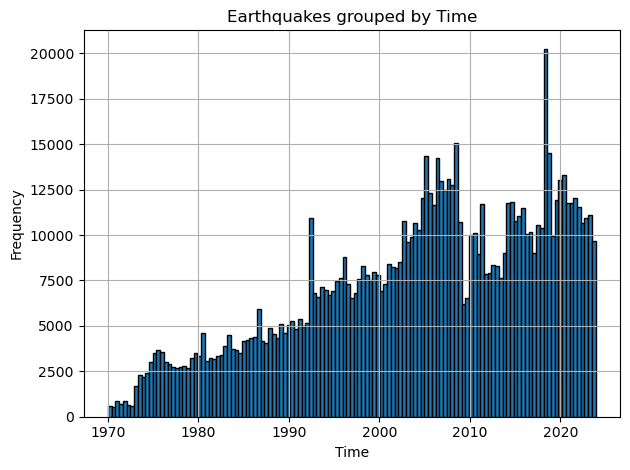

In [7]:
plot_earthquakes_time_histogram(earthquake_db)

Thanks to this graph, we observe that the number of earthquakes recorded increases linearly over the years, until 1995. It looks that from 1995, the number of earthquakes detected tends to be stabilised and more uniforme. However, the earth has always been subject to many earthquakes, and the real number of earthquake doesn't increase over the years. The fact that we observe more and more earthquakes on our data is due the increasing number of sismometers.

We are dealing with a big amount of data that we should reduce. We decide to drop the data before 1995 so that we get a more uniform distribution of our earthquakes.

Division in cells

To analyse the distribution of earthquakes across the globe, we want to split the map into small cells. This will allow us to make clusters, to assess risk areas and to have a better undertanding of our data.
The cells will be squared to simplify the problem. 
The cells have to cover the surface of cities such as London (1570 km^2). So the cells will be approximately 39*39 m^2.

---

### Mathematically determine threshold year to get poissonian data

In [8]:
earthquakes_filtered = earthquake_db[['time', 'mag']].copy()
earthquakes_filtered['time'] = pd.to_datetime(earthquakes_filtered['time'])
earthquakes_filtered['year'] = earthquakes_filtered['time'].dt.year
year_counts = earthquakes_filtered['year'].value_counts().sort_index()
year_counts_list = year_counts.tolist()

In [9]:
from scipy.stats import linregress

In [10]:
cumulative_sum = [sum(year_counts_list[:i+1]) for i in range(len(year_counts_list))]
years = year_counts.index.tolist()

#### Linear regression over years

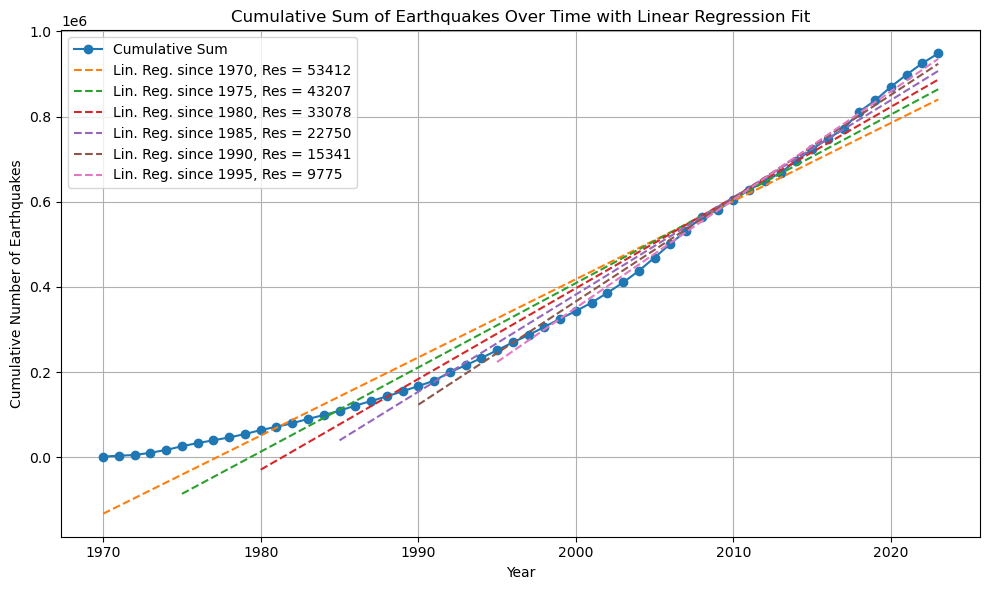

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(years, cumulative_sum, marker='o', linestyle='-', label='Cumulative Sum')

year_min_res = None

for i in range(len(years)):
    prev_res = float('inf')
    if years[i]<=current_year-25 and i%5 == 0 : #
        x = np.array(years[i:])
        y = np.array(cumulative_sum[i:])
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        linear_fit = slope * x + intercept
        residual = np.mean(np.abs(y - linear_fit))
        if residual < prev_res :
            prev_res = residual
            year_min_res = years[i]
            plt.plot(years[i:], linear_fit, linestyle='--', label=f'Lin. Reg. since {years[i]}, Res = {round(residual)}')

plt.xlabel('Year')
plt.ylabel('Cumulative Number of Earthquakes')
plt.title('Cumulative Sum of Earthquakes Over Time with Linear Regression Fit')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
earthquakes_filtered = earthquakes_filtered[earthquakes_filtered['year'] >= year_min_res]

#### Linear regression over magnitude

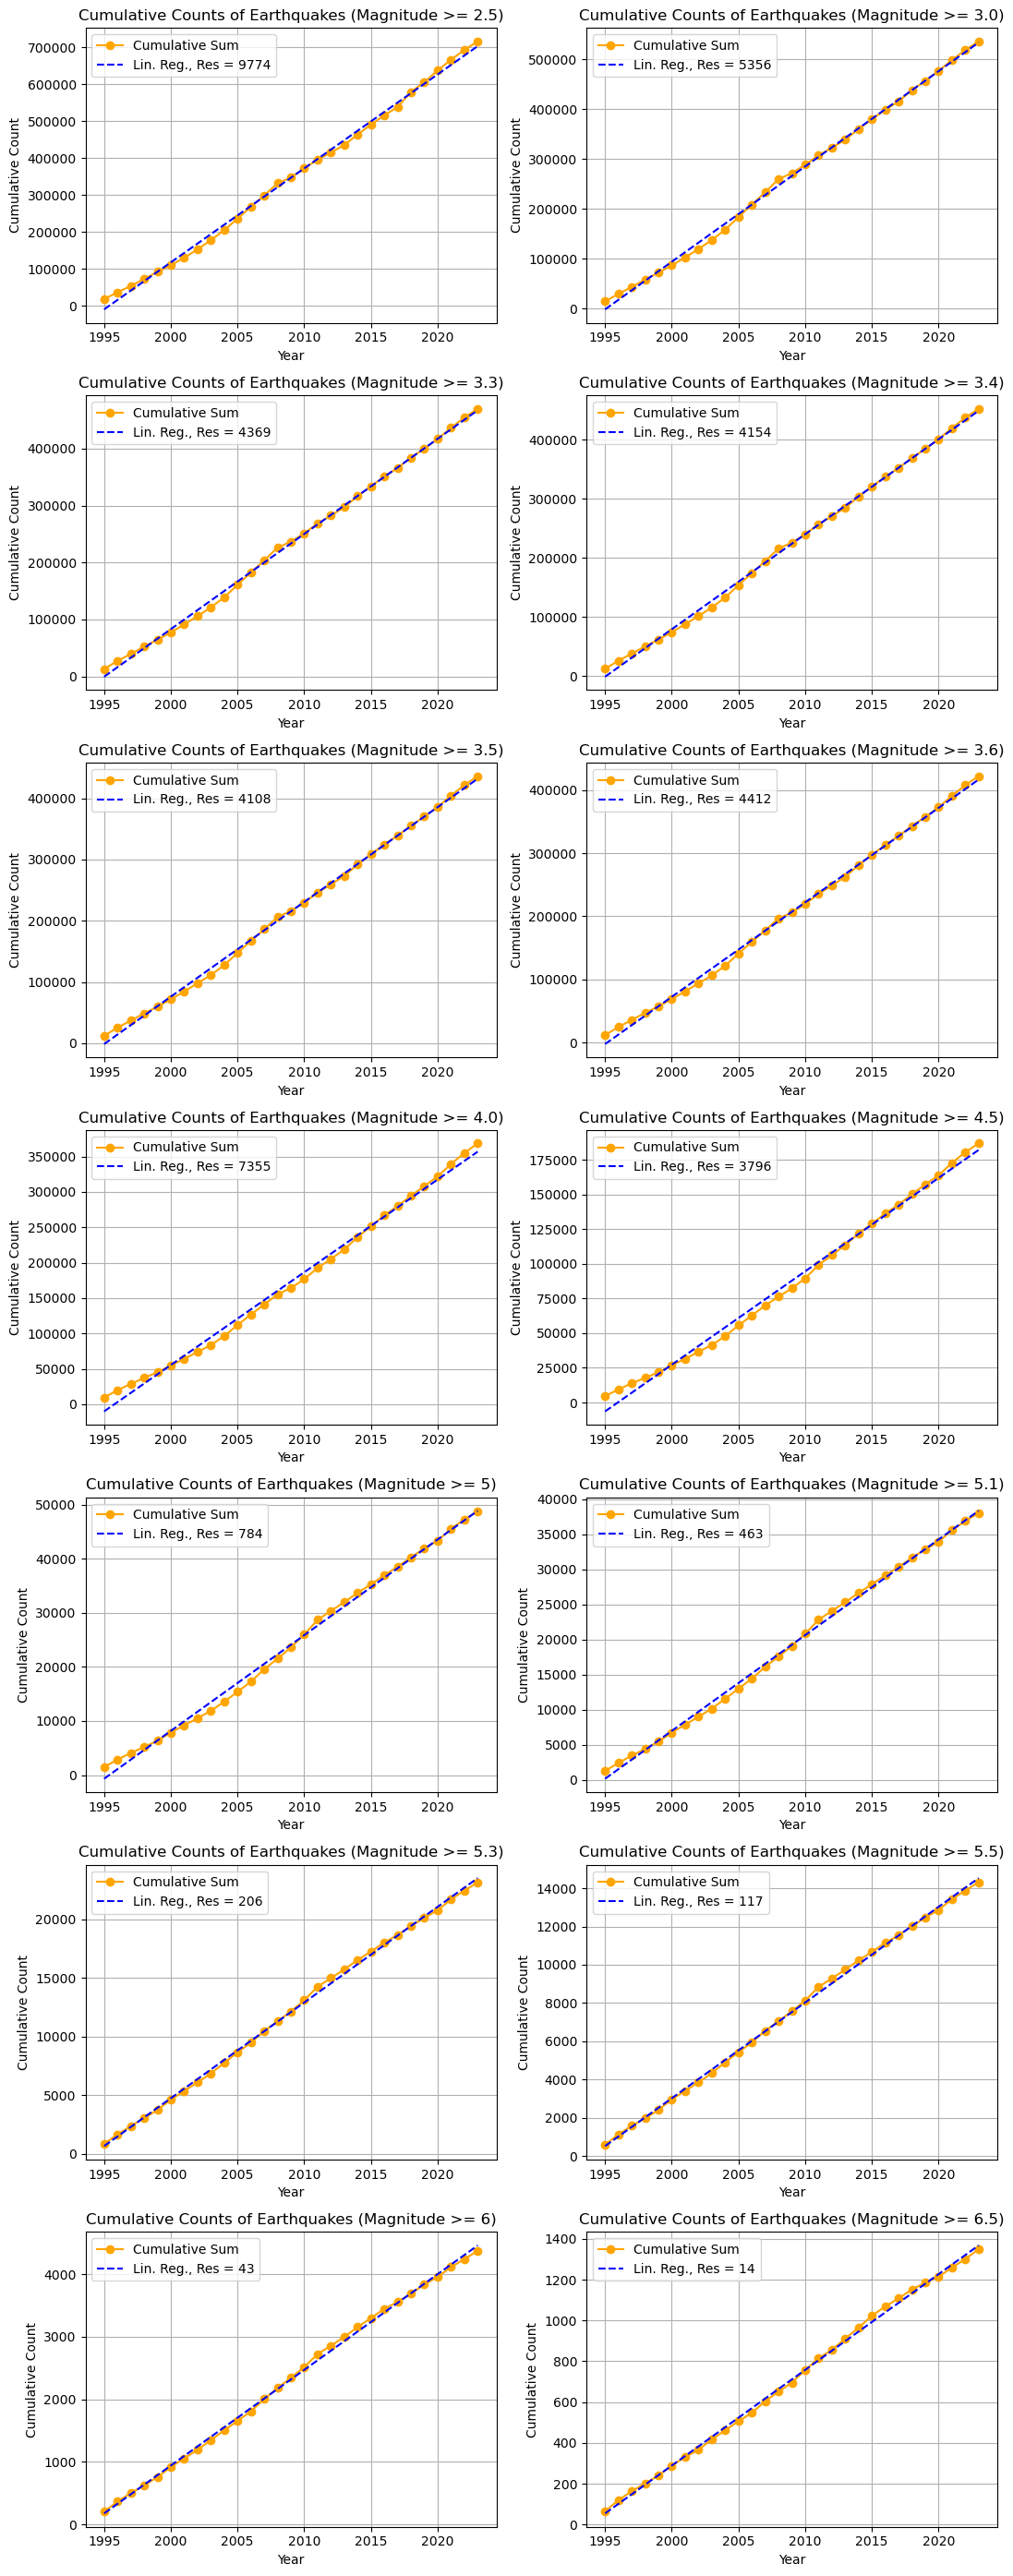

In [13]:
magnitude_thresholds = [2.5, 3.0, 3.3, 3.4, 3.5, 3.6 ,4.0, 4.5, 5, 5.1, 5.3, 5.5, 6, 6.5]
small_earthquakes_treshold = 5

small_earthquakes_res = {}
big_earthquakes_res = {}

num_rows = len(magnitude_thresholds) // 2 + len(magnitude_thresholds) % 2
fig, axs = plt.subplots(num_rows, 2, figsize=(11, 4 * num_rows))

for idx, threshold in enumerate(magnitude_thresholds):
    row, col = divmod(idx, 2)
    ax = axs[row, col]

    thresholded_data = earthquakes_filtered[earthquakes_filtered['mag'] >= threshold]

    # Calculate the cumulative sum of earthquakes for the thresholded data
    year_counts = thresholded_data['year'].value_counts().sort_index()
    year_counts_list = year_counts.tolist()
    cumulative_sum = [sum(year_counts_list[:i + 1]) for i in range(len(year_counts_list))]
    years = year_counts.index.tolist()

    x = np.array(years)
    y = np.array(cumulative_sum)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    linear_fit = slope * x + intercept
    residual = np.mean(np.abs(y - linear_fit))
    
    if threshold < small_earthquakes_treshold :
        small_earthquakes_res[threshold] = residual
    else:
        big_earthquakes_res[threshold] = residual

    ax.plot(years, cumulative_sum, color = 'orange', marker='o', linestyle='-', label='Cumulative Sum')
    ax.plot(years, linear_fit, color = 'blue', linestyle='--', label=f'Lin. Reg., Res = {round(residual)}')

    ax.set_xlabel('Year')
    ax.set_ylabel('Cumulative Count')
    ax.set_title(f'Cumulative Counts of Earthquakes (Magnitude >= {threshold})')
    ax.legend()
    ax.grid(True)

# Remove empty subplots if the number of thresholds is not a multiple of 2
if len(magnitude_thresholds) % 2 == 1:
    axs[-1, -1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
previous_value = None
noise_key_threshold = None
previous_key = None

for key, value in small_earthquakes_res.items():
    
    if previous_value is not None and value > previous_value:
        noise_key_threshold = previous_key
        break
    
    previous_key = key
    previous_value = value
    
noise_key_threshold

3.5

In [15]:
previous_value = None
key_threshold = 5

for key, value in big_earthquakes_res.items():
    
    if previous_value is not None and value > previous_value:
        key_threshold = key
    
    previous_value = value
    
key_threshold

5

In [16]:
earthquake_db['time'] = pd.to_datetime(earthquake_db['time'])
earthquake_db['year'] = earthquake_db['time'].dt.year
final_db = earthquake_db[(earthquake_db['mag'] >= noise_key_threshold) & (earthquake_db['year'] >= year_min_res)].copy().reset_index(drop=True)


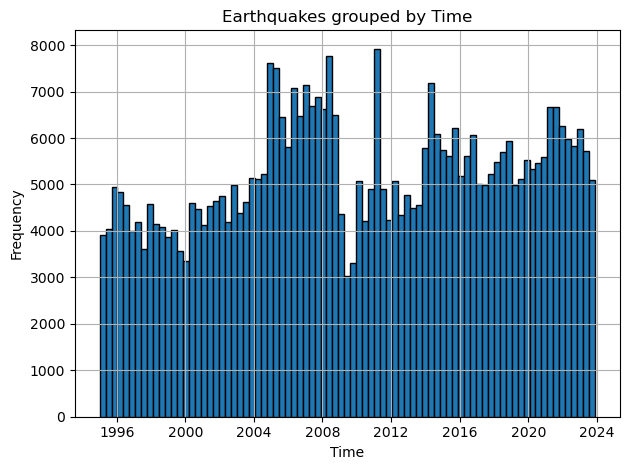

In [17]:
plot_earthquakes_time_histogram(final_db)

#### Filtered database

In [18]:
earthquake_db['time'] = pd.to_datetime(earthquake_db['time'])
earthquake_db['year'] = earthquake_db['time'].dt.year
final_db = earthquake_db[(earthquake_db['mag'] >= noise_key_threshold) & (earthquake_db['year'] >= year_min_res)].copy().reset_index(drop=True)


In [20]:
# final_db.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst,timestamp,year
count,436441.000000,436441.000000,436441.000000,436441.000000,231272.000000,328783.000000,164058.000000,391027.000000,151492.000000,2.517970e+05,163293.000000,349018.000000,4.364410e+05,436441.000000
mean,6.959316,29.390476,76.330835,4.406938,48.839224,119.668276,3.669792,0.877969,8.214042,1.771473e+01,0.130023,25.119427,1.268191e+09,2009.690293
std,29.908220,120.931827,124.226494,0.497297,70.421386,59.509024,4.923718,0.315398,3.814893,3.622427e+03,0.075295,45.746968,2.566715e+08,8.133964
min,-84.422000,-179.999700,-3.740000,3.500000,0.000000,0.000000,0.000000,-1.000000,0.000000,-1.000000e+00,0.000000,0.000000,7.889185e+08,1995.000000
25%,-17.028000,-73.569000,10.000000,4.100000,14.000000,75.800000,1.035000,0.690000,5.800000,1.900000e+00,0.078000,4.000000,1.068473e+09,2003.000000
50%,5.139000,72.236000,33.000000,4.400000,25.000000,113.100000,2.256000,0.880000,7.900000,6.000000e+00,0.119000,11.000000,1.267559e+09,2010.000000
75%,34.317200,140.026700,73.400000,4.700000,52.000000,152.000000,4.266000,1.070000,10.460000,9.762000e+00,0.163000,25.000000,1.489040e+09,2017.000000
max,87.386000,180.000000,735.800000,9.100000,934.000000,358.800000,64.498000,69.320000,99.000000,1.773552e+06,5.000000,854.000000,1.701067e+09,2023.000000


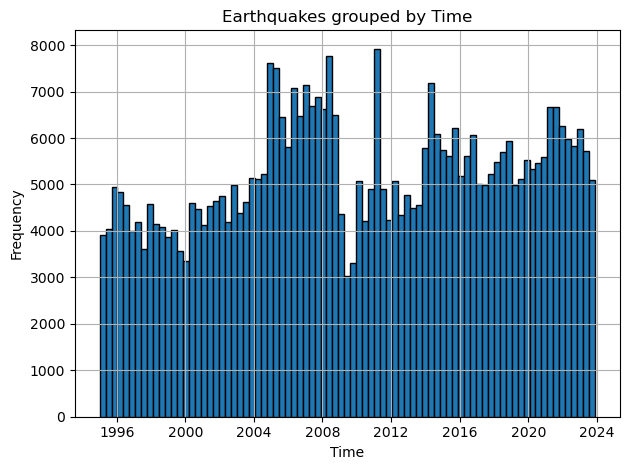

In [19]:
plot_earthquakes_time_histogram(final_db)

---

### Explanation :

    We know that big earthquake (mag > 5) are natural hazards. Then, the most accurate mathematical law to describe their behavior is the Poisson law.
    According to https://www.mdpi.com/2076-3417/13/3/1566 :
    "if the cumulative annual number of earthquakes over [a threshold] magnitude is approximately linear, then the seismic catalog is complete and Poissonian for a given threshold magnitude during a specific period of time."

    As the number of seismic stations progressively increased since the middle of the XXth century, we detect more earthquakes than before, also for low magnitude. In order to work on data which is not biased because of the technological evolution since 1950, we need to fix a threshold year and threshold magnitude thanks to linear regression over the cumulative distribution of earthquakes. The objective is to determine the year since our CDF for earthquakes until now has the lowest residual.
    We add limitations : 
        - we want to work on quite historical data. then, we want at least 25 years of past data (to work sufficient data)
        - we consider earthquakes as 'big' if they magnitude is equal or greater than 5.

        - we want a linear CDF of earthquakes over a specific magnitude. We expect the residual to reduce progressively as the magnitude threshold increases. However, very small magnitude earthquakes can be noisy, so they can skew our data and lead to a local residual minimum. We need to retrieve this local minimum and use it as a threshold to consider the data to keep.
        - we know that only few earthquakes occur over a mag greater or equal than 7, then it's possible that the residual fluctuates with a threshold over 7. We will not calculates the residual for such a magnitude.

## Results :

    Threshold year : 1995
    Threshold filter noise mag : 3.5 (the residual of the linear regression admits a local minimum for mag = 3.5, meaning it's too noisy before)
    also called lower magnitude cut-off
    Threshold filter big shock mag : 5 (the residual of the linear regression decreases progressively when the mag is over 5 which is expected)

    Conclusion : our data is complete and possonian since 1995 and with a threshold magnitude of 3.5. Then, we will drop every rows of data if the mag lower than 3.5 and before 1995. The residual value of the linear regression decreases progressively when the magnitude is greater than 5. Then, as 5 is our threshold fixed value for earthquakes, and as the cumulative distribution is approximately linear for this value, we conclude that it's a good value to say a earthquake is big.